In [6]:
## if true, will only run on one sample that is provided with code for grading purposes 
runonsample = True

## run on dataset is dependent on all data being available in the specified path
runondataset = False

In [7]:
if runondataset:
  from google.colab import drive
  drive.mount('/content/drive')
  rootPath = '/content/drive/My Drive/DL_CV_FinalProject/'
  #dataPath = '/content/data/'
  ourdata_path = rootPath + 'Datasets/our_fall_dataset/'
  urfd_path = rootPath + 'URFD_Videos/'


In [8]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [9]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
#from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import sys
import time
import pickle
import glob
import matplotlib.pyplot as plt
import tqdm
import pandas as pd 
import glob

In [10]:
## Check for GPU 
gpu_check = torch.cuda.is_available()
print(gpu_check)

if runondataset:
  ourDataset = sorted(glob.glob(ourdata_path + '*'))
  urfdDataset = sorted(glob.glob(urfd_path + '*'))

True


In [11]:
## Initialize class for predictor functions
class ReturnPredictions(object):
    def __init__(self,cfg):
        self.predictor = DefaultPredictor(cfg)
        self.metadata = MetadataCatalog.get(
                cfg.DATASETS.TEST[0] if len(cfg.DATASETS.TEST) else "__unused")

    def _frame_from_video(self,video):
        print(video)
        while video.isOpened():
            success,frame = video.read()
            if success:
                yield frame
            else:
                break

    def run_on_video(self,video):
        frame_gen = self._frame_from_video(video)
        for frame in frame_gen:
            
            yield self.predictor(frame),frame

    def run_on_image(self,image):
      # Convert image from OpenCV BGR format to Matplotlib RGB format.
      yield self.predictor(image),image


## Load and setup model and predictor
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

predictor = ReturnPredictions(cfg)


In [12]:
def resizeImg(orig_frame, scale):
  # resize input image to lower dimensionality
  width = int(orig_frame.shape[1] * scale)
  height = int(orig_frame.shape[0] * scale)
  dim = (width, height)
  resized = cv2.resize(orig_frame, dim, interpolation = cv2.INTER_AREA)
  return resized

def scaleArea(orig_frame, targetArea=(512*288)):
  frameArea = orig_frame.shape[0]*orig_frame.shape[1]
  s = np.sqrt(targetArea/frameArea)
  dim = (int(orig_frame.shape[1]*s),int(orig_frame.shape[0]*s))
  resized = cv2.resize(orig_frame, dim, interpolation = cv2.INTER_AREA)
  return resized,s

def resizeKPB(keyPoints,bbox, scale):
  # rescale keypoints and bounding boxes to match new image dimensions 
  keyPoints[:,:-1] = keyPoints[:,:-1]*scale
  bbox = bbox*scale
  return keyPoints,bbox


def visualize(u, v):
  # visualizes Optical Flow
  plt.figure(1,figsize=(8,5))
  width = u.shape[1]
  height = u.shape[0]
  x = np.arange(0, width, 1)
  y = np.arange(0, height, 1)
  x, y = np.meshgrid(x, y)

  step = 10

  plt.title('Optical Flow')

  plt.quiver(x[::step, ::step], y[::step, ::step],
            u[::step, ::step], v[::step, ::step],
            color='r', pivot='middle', headwidth=2, headlength=3)
  plt.gca().invert_yaxis()

  plt.tight_layout()

def movAvg(signal,win=5):
  # moving average 
  out = np.convolve(signal, np.ones(win)/win, mode='same')
  return out

def deriv(signal,fps=30):
  # take deriv 
  idx = int(np.argwhere(signal!=None)[0])
  out = signal.copy()
  out[idx+1:] = np.diff(out[idx:])/(1/fps)
  return out

def filter_ori_mask(oris):
  binSizeAng = 360/16
  lowerLim = binSizeAng
  upperLim = 7*binSizeAng
  skipAnglesLow = 4*binSizeAng
  skipAnglesHigh = 5*binSizeAng

  mask = np.logical_and(oris>lowerLim,oris<upperLim)

  # out = oris * mask

  return mask 

def mag_ori_win(mags,oris):
  # get average of magnitudes that correspond to the target orietnation 
  binSizeAng = 360/16
  lowerLim = binSizeAng
  upperLim = 7*binSizeAng
  skipAnglesLow = 4*binSizeAng
  skipAnglesHigh = 5*binSizeAng

  mask = np.logical_and(oris>lowerLim,oris<upperLim)
  
  outMags = mags[mask]
  
  if len(outMags)==0:
    return 0
  else:
    return np.mean(outMags)


In [13]:
def run_detector_video(videoPath,classThresh=5,vis=False):
  storeKeypoints = [] 
  storeFrames = [] # store grayscale frames
  storeBBox = []
  store_flow_mat = []
  storeFlow = []
  storeOrient = []
  storeBin = []
  storeBoxH = []
  storeBoxW = []

  # arrays of 0s to append when no person present 
  noPointsArray = np.zeros((17,3))
  noBoxArray = np.zeros(4)
  personThresh = 0.8

  # create detectron points and bounding box generator 
  vid = cv2.VideoCapture(videoPath)
  output_generator = predictor.run_on_video(vid) 

  imgID = 0

  #scale_factor = 0.3 # for resizing 

  start_track = False
  count_valid = 0

  # iterate through frames 
  for output_frame in output_generator:

    # scale factor = how much to decrease dimensionality --> helps with OF compute needed 
    if vis:
      print('---------------- Image Number: ',imgID)

    output = output_frame[0]
    frame = output_frame[1]

    # scale image down 
    #g_frame = resizeImg(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY),scale_factor)
    g_frame,_ = scaleArea(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
    
    storeFrames.append(g_frame)

    # extract values from output 
    keypoints_all = output['instances'].pred_keypoints.cpu().numpy()
    person_scores = output['instances'].scores.cpu().numpy()
    bound_box = output['instances'].pred_boxes.tensor.cpu().numpy()

    # extract indices of cases where person is detected 
    idx_scores_valid = np.argwhere(person_scores>personThresh)
    num_valid = len(idx_scores_valid)

    # skip the first frame 
    if imgID == 0:
      storeKeypoints.append(noPointsArray)
      storeBBox.append(noBoxArray)
      imgID += 1
      continue

    # calculate Dense Optical Flow between current image and previous image 
    flow = cv2.calcOpticalFlowFarneback(storeFrames[-2], storeFrames[-1], None, 0.5, 3, 25, 3, 5, 1.2, 0)
    if vis:
      print('showing vis') 
      visualize(flow[:,:,0], flow[:,:,1])

    imgID += 1

    if len(idx_scores_valid) == 0:
      # if no person detected 

      if vis:
        print('Could not detect person!')
        plt.show()
      storeKeypoints.append(noPointsArray)
      storeBBox.append(noBoxArray)
      storeBoxH.append(0) # store box height
      storeBoxW.append(0) # store box width

      # magnitude based on all pixels in image
      u = flow[:,:,0]
      v = flow[:,:,1]

      #get magnitude and orientation
      mag = np.sqrt(u**2 + v**2)
      ori = np.arctan2(v, u) * 180/np.pi
      ori[ori < 0] += 360

      storeFlow.append(mag_ori_win(mag,ori))
      storeOrient.append(np.mean(ori))
      
    else:    
      if vis:
        print("All Scores:",person_scores)

      # resize RGB image for showing figure 
      imgCopy,scale_factor = scaleArea(cv2.cvtColor(frame.copy(),cv2.COLOR_BGR2RGB))

      # resize kps and bboxes 
      key,box = resizeKPB(keypoints_all[np.argmax(person_scores)],
                          bound_box[np.argmax(person_scores)], 
                          scale_factor)

      # extract pixels that are within the bounding box of the current frame 
      u = flow[int(box[1]):int(box[3]),int(box[0]):int(box[2]),0]
      v = flow[int(box[1]):int(box[3]),int(box[0]):int(box[2]),1]

      mag = np.sqrt(u**2 + v**2)
      ori = np.arctan2(v, u) * 180/np.pi
      ori[ori < 0] += 360
      storeFlow.append(mag_ori_win(mag,ori))
      storeOrient.append(np.mean(ori))

      storeKeypoints.append(key)
      storeBBox.append(box)

      storeBoxH.append(abs(box[3] - box[1])) # store box height
      storeBoxW.append(abs(box[2] - box[0])) # store box width

      #draw bounding boxes and key points 
      if vis:
        plt.figure(3,figsize=(8,5))
        print('---height,width',(abs(box[3] - box[1]),abs(box[2] - box[0])))
        cv2.rectangle(imgCopy, (box[0],box[1]), (box[2],box[3]), (255,0,0),2)
        for pt in key:
          #print('Confidence = ',pt[2])
          if pt[2] > 0.1:
            cv2.circle(imgCopy, (pt[0],pt[1]), 2, (0,255,0), -1)
        plt.imshow(imgCopy)
      
      if vis:
        plt.show()

  storeKeypoints_ = np.stack(storeKeypoints,axis=0)
  storeBBox_ = np.stack(storeBBox,axis=0)
  storeFrames_ = np.stack(storeFrames,axis=0)
  storeFlow_ = np.array(storeFlow)
  storeOrient_ = np.array(storeOrient)
  bins_ = np.array(storeBin)
  boxH = np.array(storeBoxH)
  boxW = np.array(storeBoxW)

  mvAvgFlow_ = movAvg(storeFlow_,win=5)
  derivFlow_ = deriv(mvAvgFlow_,fps=30)

  fallClass_,fallsStart_,fallsEnd_ = getFallFrame(derivFlow_,boxW,boxH,thresh=classThresh)

  return storeFlow_, mvAvgFlow_, derivFlow_, fallClass_, fallsStart_, fallsEnd_

In [21]:
def reduce_array(signal):
  idxNonZero = np.nonzero(signal)
  signal=signal[idxNonZero]
  return signal

def getFallFrame(deriv_of_signal,box_width, box_height,thresh=3,win=15):
  # classify 

  smoothed_signal = movAvg(deriv_of_signal,win=win)
  # print('max of acceleration:',np.max(smoothed_signal))
  # print('min of acceleration:',np.min(smoothed_signal))

  all_candidate_onset = np.argwhere(smoothed_signal > thresh) #+ idx
  all_candidate_offset = np.argwhere(smoothed_signal < -thresh) #+ idx

  # print('onset',smoothed_signal[all_candidate_onset])
  # print('offset',smoothed_signal[all_candidate_offset])

  if (len(all_candidate_onset) == 0) or (len(all_candidate_offset) == 0):
    f_class = 0
    idx_start = 0
    idx_end = 0
  else:
    f_class = 1
    idx_start = int(all_candidate_onset[0])
    idx_end = int(all_candidate_offset[0])

    ## update class to 0 if conditions are met
    pm = 2
    height_start=box_height[idx_start-pm:idx_start+pm]
    width_start=box_width[idx_start-pm:idx_start+pm]
    height_end=box_height[idx_end-pm:idx_end+pm]
    width_end=box_width[idx_end-pm:idx_end+pm]
    if (not np.any(height_start)==False) and (not np.any(height_end)==False): 
      height_start=reduce_array(height_start)
      width_start=reduce_array(width_start)
      height_end=reduce_array(height_end)
      width_end=reduce_array(width_end)
      HW_ratio_start=np.amax(height_start/width_start)
      HW_ratio_end=np.amin(height_end/width_end)
      print('HW_ratio_start:',HW_ratio_start)
      print('HW_ratio_end:', HW_ratio_end)
      if HW_ratio_end >= HW_ratio_start:
        f_class = 0
        idx_start = 0
        idx_end = 0
      else:
        if round(HW_ratio_end,2)<=1:
          f_class = 1
          idx_start = int(all_candidate_onset[0])
          idx_end = int(all_candidate_offset[0])
        else:
          f_class = 0
          idx_start = 0
          idx_end = 0

  return f_class, idx_start, idx_end

Plotting Cell

In [22]:
runPlot = False
if runPlot:
  ls=12
  fs=12
  plt.rc('xtick',labelsize=ls)
  plt.rc('ytick',labelsize=ls)

  outMaster_fname = rootPath + 'results/our_dataset_master.csv'
  outMaster = pd.read_csv(outMaster_fname)

  sampleName = '/content/drive/My Drive/DL_CV_FinalProject/Datasets/our_fall_dataset/kinjal-07.mov' 
  sampleID = sampleName.split('/')[-1].split('.')[0]

  # outMaster_fname = rootPath + 'results/urfd_master.csv'
  # outMaster = pd.read_csv(outMaster_fname)

  # sampleName = '/content/drive/My Drive/DL_CV_FinalProject/URFD_Videos/fall-01-cam0.mp4' 
  # sampleID = sampleName.split('/')[-1][:-9]
  
  print('-----Running Sample:', sampleID)
  print('Fall Class = ', outMaster[outMaster.sequence_name==sampleID]['fall_label'].item() )
  fallStart_label=outMaster[outMaster.sequence_name==sampleID]['fall_start_frame'].item()
  fallEnd_label=outMaster[outMaster.sequence_name==sampleID]['fall_end_frame'].item()
  optFlow, mvAvgFlow, derivFlow, fallPred, fallStart, fallEnd = run_detector_video(sampleName,classThresh=7,vis=False)
  print('Fall Prediction = ', fallPred)

  f_t = np.arange(len(mvAvgFlow))/30

  ## Ax1 = Velocity
  plt.figure(figsize=(8,5))
  plt.plot(f_t,mvAvgFlow,'k',label='Velocity\n(pixel/s)')
  plt.plot(f_t,movAvg(derivFlow,win=15),'k:',label='Acceleration\n(pixel/$s^2$)')

  if fallStart != 0:
    plt.axvline(fallStart/30,color=(0,0,1),label='Onset Prediction',ls='--',alpha=0.5)

  if (fallStart_label != 0) or (np.isnan(fallStart_label)==False):
    plt.axvline(fallStart_label/30,color=(0,0,0.75),label='Onset Label',ls='-',alpha=0.5)

  if fallEnd != 0:
    plt.axvline(fallEnd/30,color=(0,1,0),label='End Prediction',ls='--',alpha=0.5)

  if (fallEnd_label != 0) or (np.isnan(fallEnd_label)==False):
    plt.axvline(fallEnd_label/30,color=(0,0.75,0),label='End Label',ls='-',alpha=0.5)

  plt.axhline(3.5,color=(1,0,0),label='Onset Thresh',ls='-',alpha=0.5)
  plt.axhline(-3.5,color=(0.8,0,0.8),label='Term Thresh',ls='-',alpha=0.5)

  ylims = plt.axes().get_ylim()
  xlims = plt.axes().get_xlim()
  plt.legend(loc='lower left',fontsize=fs)

  plt.xlim((0,xlims[1]))
  plt.ylim((ylims[0]-8,ylims[1]))
  # plt.ylabel('')
  plt.xlabel('Time(s)',fontsize=fs)
  plt.tight_layout()
  plt.show()

OUR DATASET

In [23]:
if runondataset:
  outMaster_fname = rootPath + 'results/our_dataset_master.csv'
  saveData_fname = rootPath + 'results/our_dataset_OUTPUT.csv'
  outMaster = pd.read_csv(outMaster_fname)

  for sampleName in ourDataset:
    sampleID = sampleName.split('/')[-1].split('.')[0]
    print('-----Running Sample:', sampleID)
    print('Fall Class = ', outMaster[outMaster.sequence_name==sampleID]['fall_label'] )
    optFlow, mvAvgFlow, derivFlow, fallPred, fallStart, fallEnd = run_detector_video(sampleName,classThresh=7)
    print('Fall Prediction = ', fallPred)
    outMaster.loc[outMaster.sequence_name==sampleID,'fall_pred'] = fallPred
    outMaster.loc[outMaster.sequence_name==sampleID,'fall_start_pred'] = fallStart
    outMaster.loc[outMaster.sequence_name==sampleID,'fall_end_pred'] = fallEnd
    outMaster.to_csv(saveData_fname)

  #outMaster.to_csv(saveData_fname)   

In [24]:
if runondataset:
  outMaster_fname = rootPath + 'results/urfd_master.csv'
  saveData_fname = rootPath + 'results/urfd_OUTPUT.csv'
  outMaster = pd.read_csv(outMaster_fname)

  for sampleName in urfdDataset:
    sampleID = sampleName.split('/')[-1][:-9]#.split('.')[0]
    print('-----Running Sample:', sampleID)
    print('Fall Class = ', outMaster[outMaster.sequence_name==sampleID]['fall_label'] )
    optFlow, mvAvgFlow, derivFlow, fallPred, fallStart, fallEnd = run_detector_video(sampleName,classThresh=7)
    print('Fall Prediction = ', fallPred)
    outMaster.loc[outMaster.sequence_name==sampleID,'fall_pred'] = fallPred
    outMaster.loc[outMaster.sequence_name==sampleID,'fall_start_pred'] = fallStart
    outMaster.loc[outMaster.sequence_name==sampleID,'fall_end_pred'] = fallEnd
    outMaster.to_csv(saveData_fname,index=False)

  #outMaster.to_csv(saveData_fname)  

-----Running Sample: erica-11
Fall Label =  1
Start Frame Ground Truth =  115.0
End Frame Ground Truth =  135.0
<VideoCapture 0x7fbe56b06450>
HW_ratio_start: 1.7263208178788343
HW_ratio_end: 0.9385409997918811
Fall Predictions =  1
Start Frame Detected =  104
End Frame Detected =  122


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


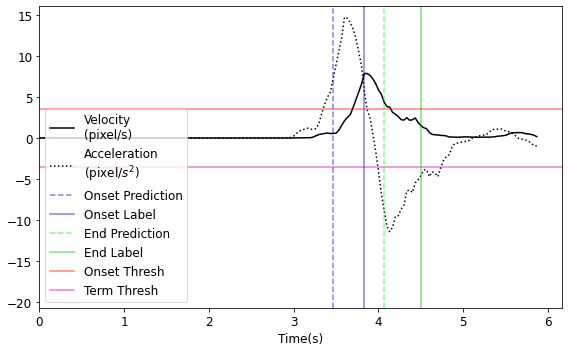

In [25]:
colab = True
local = False
ViewSetting = False ## Change view setting if you would like to see OF and Keypoints
if runonsample:
  if colab:
    annotationsFile = 'our_dataset_master.csv'
    sampleName = 'erica-11.mp4'
    outMaster = pd.read_csv(annotationsFile)
    sampleID = sampleName.split('/')[-1].split('.')[0]
    print('-----Running Sample:', sampleID)
    print('Fall Label = ', outMaster[outMaster.sequence_name==sampleID]['fall_label'].item() )
    print('Start Frame Ground Truth = ', outMaster[outMaster.sequence_name==sampleID]['fall_start_frame'].item() )
    print('End Frame Ground Truth = ', outMaster[outMaster.sequence_name==sampleID]['fall_end_frame'].item() )
    optFlow, mvAvgFlow, derivFlow, fallPred, fallStart, fallEnd = run_detector_video(sampleName,classThresh=7)
    print('Fall Predictions = ', fallPred)
    print('Start Frame Detected = ', fallStart)
    print('End Frame Detected = ',fallEnd)

  if local:
    annotationsFile = './our_dataset_master.csv'
    sampleName = './erica-11.mp4'
    outMaster = pd.read_csv(annotationsFile)
    sampleID = sampleName.split('/')[-1].split('.')[0]
    print('-----Running Sample:', sampleID)
    print('Fall Label = ', outMaster[outMaster.sequence_name==sampleID]['fall_label'].item() )
    print('Start Frame Ground Truth = ', outMaster[outMaster.sequence_name==sampleID]['fall_start_frame'].item() )
    print('End Frame Ground Truth = ', outMaster[outMaster.sequence_name==sampleID]['fall_end_frame'].item() )
    optFlow, mvAvgFlow, derivFlow, fallPred, fallStart, fallEnd = run_detector_video(sampleName,classThresh=7)
    print('Fall Predictions = ', fallPred)
    print('Start Frame Detected = ', fallStart)
    print('End Frame Detected = ',fallEnd)

  ls=12
  fs=12
  plt.rc('xtick',labelsize=ls)
  plt.rc('ytick',labelsize=ls)
  f_t = np.arange(len(mvAvgFlow))/30

  plt.figure(figsize=(8,5))
  plt.plot(f_t,mvAvgFlow,'k',label='Velocity\n(pixel/s)')
  plt.plot(f_t,movAvg(derivFlow,win=15),'k:',label='Acceleration\n(pixel/$s^2$)')
  fallStart_label=outMaster[outMaster.sequence_name==sampleID]['fall_start_frame'].item()
  fallEnd_label=outMaster[outMaster.sequence_name==sampleID]['fall_end_frame'].item()

  if fallStart != 0:
    plt.axvline(fallStart/30,color=(0,0,1),label='Onset Prediction',ls='--',alpha=0.5)

  if (fallStart_label != 0) or (np.isnan(fallStart_label)==False):
    plt.axvline(fallStart_label/30,color=(0,0,0.75),label='Onset Label',ls='-',alpha=0.5)

  if fallEnd != 0:
    plt.axvline(fallEnd/30,color=(0,1,0),label='End Prediction',ls='--',alpha=0.5)

  if (fallEnd_label != 0) or (np.isnan(fallEnd_label)==False):
    plt.axvline(fallEnd_label/30,color=(0,0.75,0),label='End Label',ls='-',alpha=0.5)

  plt.axhline(3.5,color=(1,0,0),label='Onset Thresh',ls='-',alpha=0.5)
  plt.axhline(-3.5,color=(0.8,0,0.8),label='Term Thresh',ls='-',alpha=0.5)

  ylims = plt.axes().get_ylim()
  xlims = plt.axes().get_xlim()
  plt.legend(loc='lower left',fontsize=fs)

  plt.xlim((0,xlims[1]))
  plt.ylim((ylims[0]-8,ylims[1]))
  # plt.ylabel('')
  plt.xlabel('Time(s)',fontsize=fs)
  plt.tight_layout()
  plt.show()